In [7]:
import numpy as np
# from multiprocess import Pool
import matplotlib.pyplot as plt
import emcee
import corner
from astropy.io import fits
from astropy.visualization import quantity_support
import astropy.units as u
from specutils import Spectrum1D
from decimal import *
quantity_support()
from astropy.io import ascii
# Figure parameters
cm = 1/2.54
plt.rcParams['figure.figsize'] = [ 8.5*3*cm, 5*3*cm]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Times New Roman",
    "font.weight": "normal",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.direction": "in",
    "ytick.direction": "in"
})
font = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 12}
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

import random
import spectres
import coronagraph as cg
print(cg.__version__)
import copy
import specutils
specutils.conf.do_continuum_function_check = False
import pickle as pkl
import os as os

1.01


In [8]:
#Random functions that I will be using throughout
def closest(x, val):
    '''''
    This function takes an array and returns the index of the cloesest member to a certain value.
    Inputs:
        x - array over which to search 
        val - value to search for
    Outputs:
       Returns index of array element closest in numerical value to the inputted value
    '''''
    arr = np.asarray(x-val)
    arr = [abs(i) for i in arr]
    return np.where(arr==min(arr))[0][0]

In [9]:
# From Carvalho, A. and Johns-Krull, C. M., “A Simple Code for Rotational Broadening of Broad Wavelength Range High-Dispersion Spectra”, Research Notes of the American Astronomical Society, vol. 7, no. 5, Art. no. 91, IOP, 2023. doi:10.3847/2515-5172/acd37e.

def rot_int_cmj(w, s, vsini, eps=0.6, nr=10, ntheta=100, dif = 0.0):
    '''
    A routine to quickly rotationally broaden a spectrum in linear time.
    INPUTS:
    s - input spectrum
    w - wavelength scale of the input spectrum
    vsini (km/s) - projected rotational velocity
    OUTPUT:
    ns - a rotationally broadened spectrum on the wavelength scale w
    OPTIONAL INPUTS:
    eps (default = 0.6) - the coefficient of the limb darkening law
    nr (default = 10) - the number of radial bins on the projected disk
    ntheta (default = 100) - the number of azimuthal bins in the largest radial annulus
                            note: the number of bins at each r is int(r*ntheta) where r < 1
    dif (default = 0) - the differential rotation coefficient, applied according to the law
    Omeg(th)/Omeg(eq) = (1 - dif/2 - (dif/2) cos(2 th)). Dif = .675 nicely reproduces the law 
    proposed by Smith, 1994, A&A, Vol. 287, p. 523-534, to unify WTTS and CTTS. Dif = .23 is 
    similar to observed solar differential rotation. Note: the th in the above expression is 
    the stellar co-latitude, not the same as the integration variable used below. This is a 
    disk integration routine.
    '''
    ns = np.copy(s)*0.0
    tarea = 0.0
    dr = 1./nr
    for j in range(0, nr):
        r = dr/2.0 + j*dr
        area = ((r + dr/2.0)**2 - (r - dr/2.0)**2)/int(ntheta*r) * (1.0 - eps + eps*np.cos(np.arcsin(r)))
        for k in range(0,int(ntheta*r)):
            th = np.pi/int(ntheta*r) + k * 2.0*np.pi/int(ntheta*r)
            if dif != 0:
                vl = vsini * r * np.sin(th) * (1.0 - dif/2.0 - dif/2.0*np.cos(2.0*np.arccos(r*np.cos(th))))
                ns += area * np.interp(w + w*vl/2.9979e5, w, s)
                tarea += area
            else:
                vl = r * vsini * np.sin(th)
                ns += area * np.interp(w + w*vl/2.9979e5, w, s)
                tarea += area
          
    return ns/tarea

# 2005 P. Eilers and H. Boelens "Asymmetric Least Squares Smoothing". Also cite Carvalho, A. S., “Modeling the Multiwavelength Evolution of the V960 Mon System”, The Astrophysical Journal, vol. 953, no. 1, Art. no. 86, IOP, 2023. doi:10.3847/1538-4357/ace2cb.

import scipy
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = scipy.sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * np.nan_to_num(y, nan=np.nanmedian(y)))
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [10]:
spec_grid = pkl.load(open('C:\\Users\\Savio\\Documents\\IGRINS-Spectra\\Grid_T_logg_IGRINS.p', 'rb')) # Replace for your disk

In [11]:
import pandas as pd
proto_table = pd.read_csv('C:\\Users\\Savio\\Documents\\IGRINS-Spectra\\standard_table_v3.txt', index_col=0)

file_idx = 17
order = 10
target = fits.open(proto_table['File'][file_idx])
wav = target[3].data[order]
flux = target[1].data[order]
original_wav = wav*10000
original_wav_vac = original_wav / (1.0 + 2.735182E-4 + 131.4182 / original_wav**2 + 2.76249E8 / original_wav**4) # Convert air wavelengths to vacuum wavelengths
wav = original_wav_vac/10000

corr = 0*u.km/u.s # If you know the radial velocity of the target beforehand, you can correct the spectra here
print("Radial velocity correction is: " + str(corr))

corr_val = np.sqrt((1 + corr.value / 299792.458) / (1 - corr.value / 299792.458))

targetspectra = Spectrum1D(flux = flux*u.erg/u.second/u.AA/u.cm/u.cm,
                           spectral_axis = wav/corr_val*u.micron
                           )# Create a Spectrum1D object for the raw spectra using the flux and spectral axis from the FITS data

average = np.nanmedian(targetspectra.flux) # Calculate the median flux value of the resampled spectra, ignoring NaNs

targetnormspectra = Spectrum1D(targetspectra.flux/average,
                               spectral_axis=targetspectra.spectral_axis
                               ) # Normalize the resampled spectra by dividing by the median flux value

temp_grid = np.linspace(2000, 7000, int(1 + (7000 - 2000) / 100))  # Temperature grid from 1200K to 7000K in 100K increments
logg_grid = np.linspace(2.5, 5, int(1 + (5 - 2.5) / 0.5))  # logg grid from 2.5 to 5.0 in 0.1 increments

lammin = wav[0]
lammax = wav[-1]
R = 45000  # Resolution to degrade the models to
wl, dwl = cg.noise_routines.construct_lam(lammin, lammax, R)
targetnormspectra = spectres.spectres(new_wavs = wl,
                                      spec_wavs = targetnormspectra[2.185*u.um:].spectral_axis.value,
                                      spec_fluxes = targetnormspectra[2.185*u.um:].flux.value
                                      )
newgrid = []
for i in range(len(spec_grid)):
    temp_slices = []
    for j in range(len(logg_grid)):
        wl, dwl = cg.noise_routines.construct_lam(lammin, lammax, R)
        flux = cg.downbin_spec(spec_grid[i][j][1], spec_grid[i][j][0] / 10000, wl, dlam=dwl)
        temp_slices.append(flux)
    newgrid.append(temp_slices)
wav = wl

newgrid = np.array(newgrid)

from scipy.interpolate import RegularGridInterpolator
interp_func = RegularGridInterpolator((temp_grid[:],
                                       logg_grid, wav),
                                       newgrid,
                                       bounds_error=False,
                                       fill_value=None)
def f_spec(wav, temp, logg):
    points = np.array([[temp, logg, w] for w in wav])
    ret = interp_func(points)
    return  ret
print('Done')

Radial velocity correction is: 0.0 km / s


c:\Users\Savio\anaconda3\envs\facundo_env\lib\site-packages\spectres\spectral_resampling.py:104: RuntimeWarning: Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (by default 0).
  warnings.warn(


Done


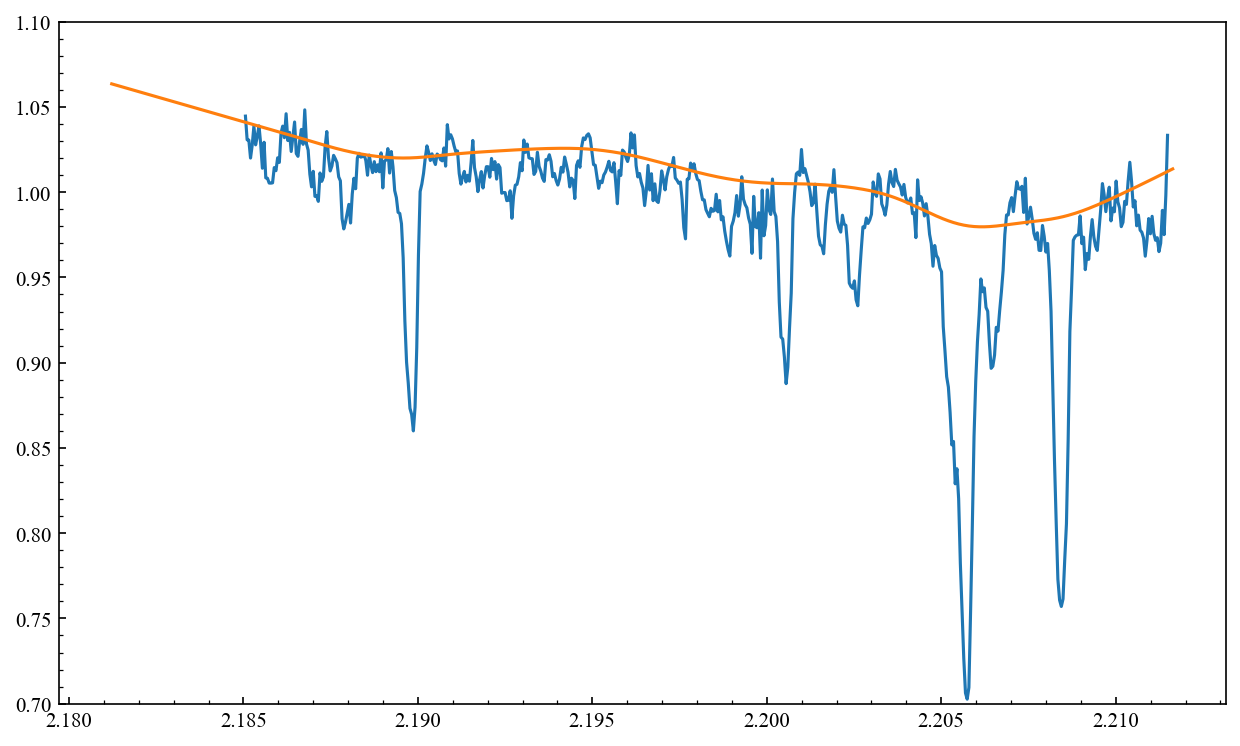

In [17]:
plt.plot(wav, targetnormspectra)
plt.plot(wav, baseline_als(targetnormspectra, 1e5, 0.95))
plt.ylim(0.7,1.1)
plt.show()

In [ ]:
def fit(start, stop, spectrum, Tmax, Tmin, loggmin, loggmax, vsinimin, vsinimax, vrmin, vrmax, rmin, rmax, nsteps, nwalkers, burn):
    start = closest(wav, start)
    stop = closest(wav, stop)
    def log_likelihood(theta, x, y):
        T, logg, vsini, vr, r = theta
        model = f_spec(wav[start:stop]/np.sqrt((1 + vr / 299792.458) / (1 - vr / 299792.458)), T, logg)
        model = rot_int_cmj(wav[start:stop], model, vsini, eps=0.6, nr=10, ntheta=100, dif = 0.0)
        model = model/baseline_als(model, 1e6, 0.95, niter=10)
        model = model + r
        model = model/baseline_als(model, 1e6, 0.95, niter=10)
        resids = model - spectrap
        weighted = (resids / 0.01) ** 2 + np.log(2 * np.pi * (0.01) ** 2)
        x = -0.5 * np.nansum(weighted)
        return x

    def log_prior(theta):
        T, logg, vsini, vr, r = theta
        if vsinimin < vsini < vsinimax and vrmin < vr < vrmax and Tmin < T < Tmax and loggmin < logg < loggmax and rmin < r < rmax:
            return 0.0
        return -np.inf

    def log_probability(theta, x, y):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, x, y)

    pos = np.zeros((nwalkers, 5)) + np.random.rand(nwalkers, 5)
    for k in pos:
        k[0] = random.uniform(Tmin, Tmax)
        k[1] = random.uniform(loggmin, loggmax)
        k[2] = random.uniform(vsinimin, vsinimax)
        k[3] = random.uniform(vrmin, vrmax)
        k[4] = random.uniform(rmin, rmax)
        
    nwalkers, ndim = pos.shape
    spectrap = copy.deepcopy(spectrum[start:stop])
    spectrap = spectrap/baseline_als(spectrap, 1e4, 0.9, niter=10)

    # with Pool(ncores) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(wav, spectrap))
    sampler.run_mcmc(pos, nsteps, progress=True)

    samples = sampler.get_chain()
    flat_samples = sampler.get_chain(discard=burn, thin=1, flat=True)
    highest_prob = np.argmax(sampler.get_log_prob())
    hp_loc = np.unravel_index(highest_prob, sampler.get_log_prob().shape)
    mle_soln = sampler.get_chain()[hp_loc]

    print('\nError estimates from emcee:')
    print('------------------------------------------------------')
    print('Parameter  -2sigma  -1sigma   median  +1sigma  +2sigma')
    for i, name in enumerate(['T', 'logg', 'vsini', 'vr', 'r']):
        quantiles = np.percentile(flat_samples[:, i], [2.275, 15.865, 50, 84.135, 97.275])
        median = quantiles[2]
        err_m2 = quantiles[0] - median
        err_m1 = quantiles[1] - median
        err_p1 = quantiles[3] - median
        err_p2 = quantiles[4] - median
        fmt = '  {:5s}   {:8.4f} {:8.4f} {:8.4f} {:8.4f} {:8.4f}'.format
        print(fmt(name, err_m2, err_m1, median, err_p1, err_p2))

    print('MLE Results:')
    for name, val in zip(['T', 'logg', 'vsini', 'vr', 'r'], mle_soln):
        print(name + ' = ' + str(val))

    fig, axes = plt.subplots(5, figsize=(4, 4), sharex=True)
    labels = ['T', 'logg', 'vsini', 'vr', 'r']
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.axvline(burn, color = 'red')
    axes[-1].set_xlabel("step number")
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(7.5, 7.5))
    corner.corner(flat_samples, bins=50, hist_kwargs={'density': True}, 
            quantiles=(.15865, 0.5, .84135), show_titles=True, 
            labels=['T', 'logg', 'vsini', 'vr', 'r'], 
            smooth=1, plot_density=True, fig=fig)
    axes = np.array(fig.axes).reshape((5, 5))
    plt.show()

    T = mle_soln[0]
    logg = mle_soln[1]
    vsini = mle_soln[2]    
    vr = mle_soln[3]
    r = mle_soln[4]
    
    model = f_spec(wav[start:stop]/np.sqrt((1 + vr / 299792.458) / (1 - vr / 299792.458)), T, logg)
    model = rot_int_cmj(wav[start:stop], model, vsini, eps=0.6, nr=10, ntheta=100, dif = 0.0)
    model = model/baseline_als(model, 1e4, 0.9, niter=10)
    model = model+r
    model = model/baseline_als(model, 1e4, 0.9, niter=10) 
    
    fig, ax1 = plt.subplots(1, figsize=(10, 5))
    plt.plot(wav[start:stop], spectrap, label='Data')
    plt.plot(wav[start:stop], model, label='Model')
    plt.xlabel('Wavelength (microns)')
    plt.ylabel('Normalized Flux')
    plt.ylim(0.5, 1.3)
    plt.xlim(wav[start], wav[stop])
    plt.legend(framealpha=0)
    plt.axhline(0, color='gray', lw=0.5)
    plt.title(f'Fit Results: T = {T:.2f} K, logg = {logg:.2f}, vsini = {vsini:.2f} km/s, r_v = {vr:.2f} km/s, r = {r:.2f}')
    plt.show()


100%|██████████| 1000/1000 [16:17<00:00,  1.02it/s]



Error estimates from emcee:
------------------------------------------------------
Parameter  -2sigma  -1sigma   median  +1sigma  +2sigma
  T       -26.2716 -11.6891 3500.9150  12.1455  25.9505
  logg     -0.0985  -0.0500   4.7858   0.0519   0.0957
  vsini    -1.0943  -0.5730  25.7250   0.5414   1.0898
  vr       -0.6580  -0.3514  10.1850   0.3355   0.6297
  r        -0.0005  -0.0004   0.0005   0.0008   0.0021
MLE Results:
T = 3498.691698436477
logg = 4.764036609536031
vsini = 25.771501026394976
vr = 10.114022323712968
r = 3.700269377483758e-05


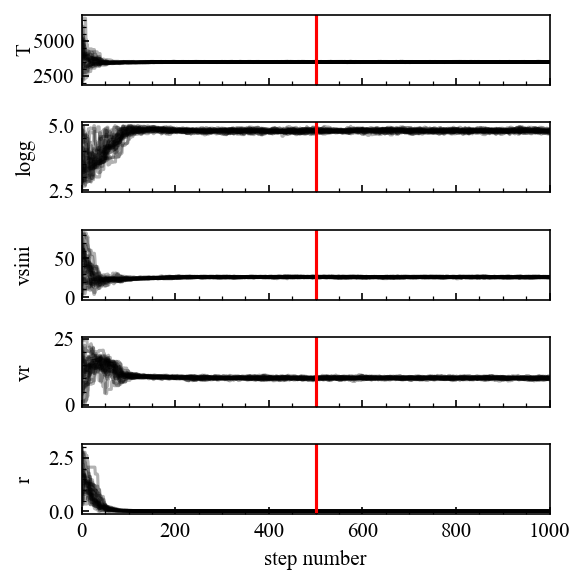

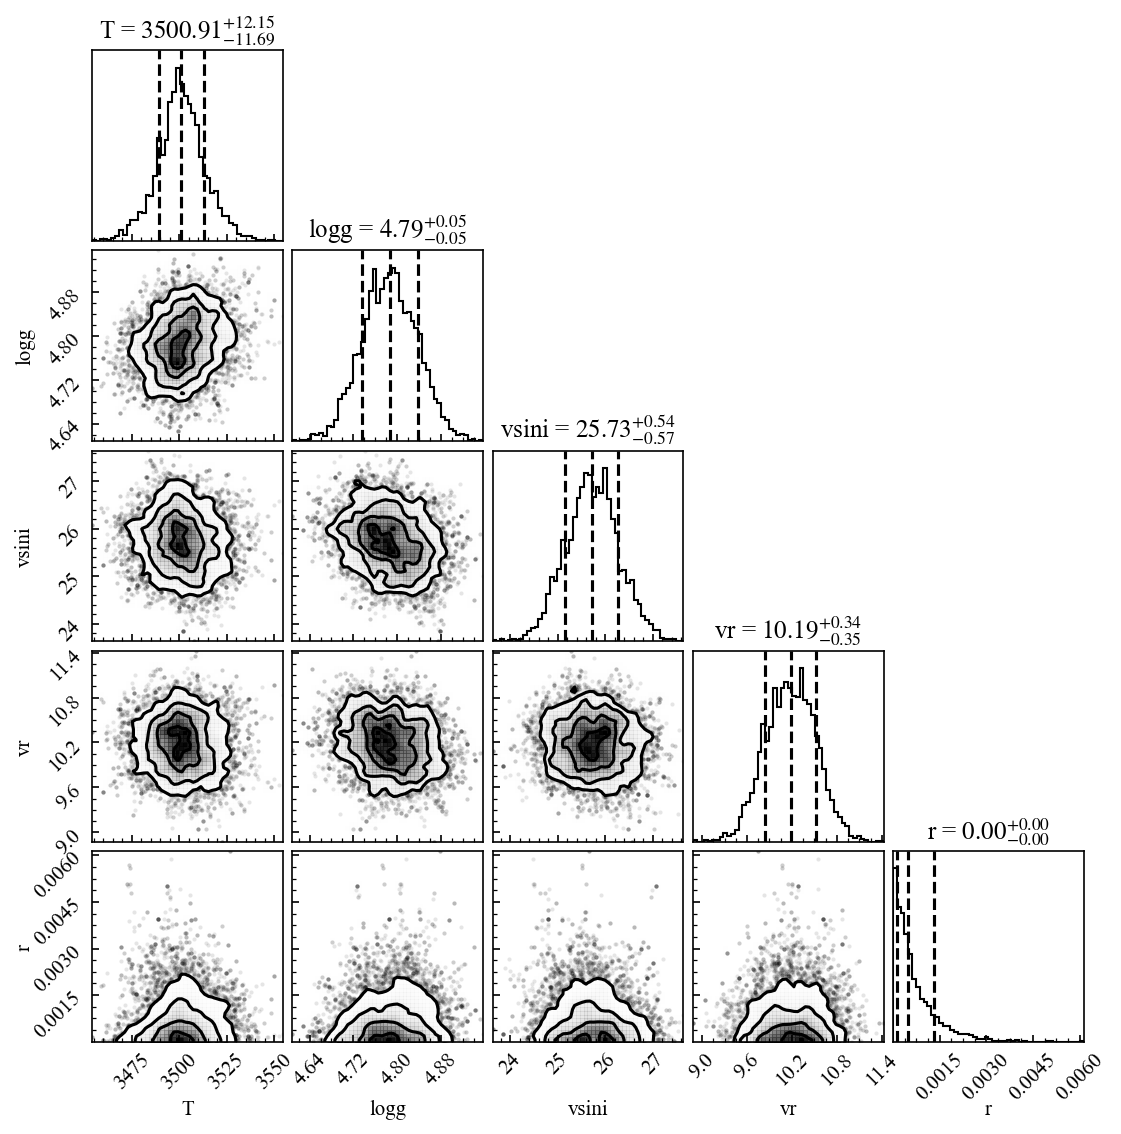

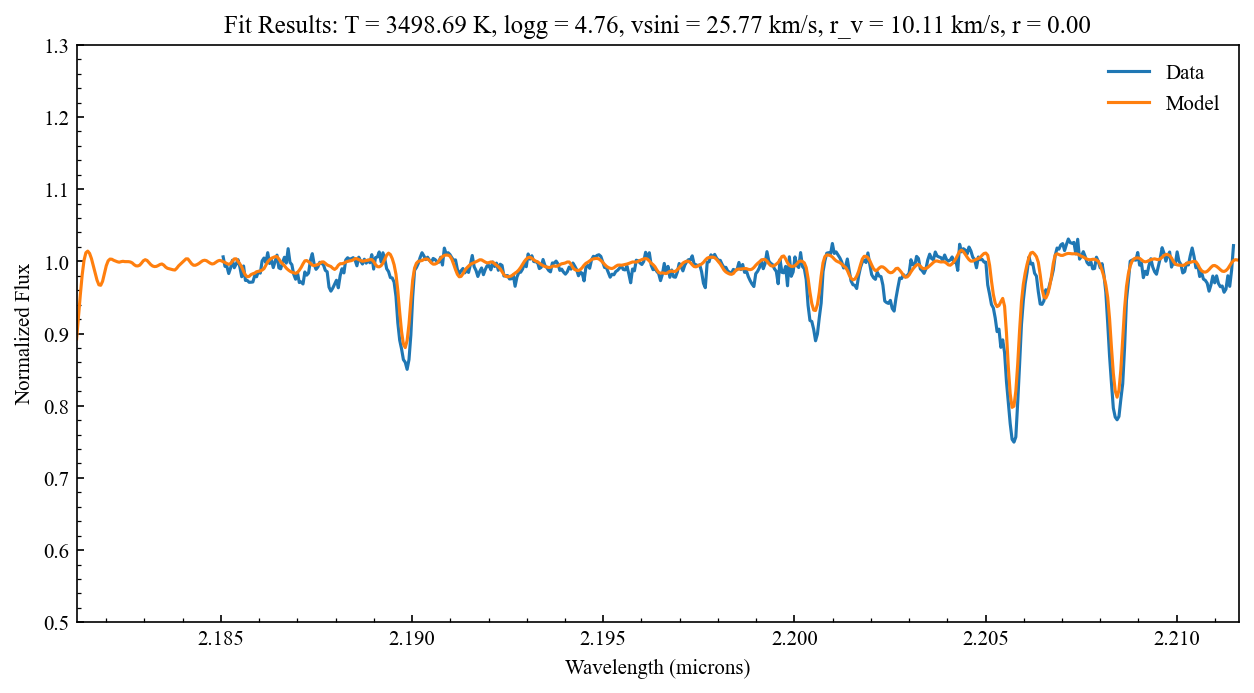

In [ ]:
fit(start = wl.min(),
    stop = wl.max(),
    spectrum = targetnormspectra,
    Tmin = 2000, Tmax = 7000,
    loggmin = 2.5, loggmax = 5,
    vsinimin = 0, vsinimax = 100,
    vrmin = 0, vrmax = 25,
    rmin = 0, rmax = 3,
    nsteps = 1000, nwalkers = 25, burn = 500)